In [1]:
# Referencing https://www.kaggle.com/antgoldbloom/xgboost-vs-betting-markets

In [2]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import math
from datetime import datetime
from time import strptime

In [3]:
df_horses = pd.read_csv("mergedHorse.csv", header=0) 

c:\users\jeff\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (66,67,68,69,70,117,118,119,120,121,122,123,124,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_horses.dropna(subset=['Track'])
def convertToNumber (s):
    stringVal = ""
    #if isinstance(s, str):
    #    print("Found not string %s %s", s, type(s))
    #print("Type and val %s %s", s, type(s))
    for c in s:
        stringVal += str(ord(c))
    return int(stringVal)
    #return ''.join(str(ord(c)) for c in s)
#Combine columns for unique id
# Merge cols 2,3,4, remove '.'s
#Need to drop last row
df_horses.drop(df_horses.index[len(df_horses)-1])
df_horses = df_horses.dropna(subset=['JockeyName'])   
df_horses['Track'] = df_horses['Track'].apply(lambda x: convertToNumber(x))

In [5]:
#This is broken
df_horses['raceID'] = df_horses['Track'].map(str) + df_horses['Date'].map(str) + df_horses['RaceNum'].map(str) + df_horses['Post'].map(str)
df_horses['raceID'] = df_horses['raceID'].replace(to_replace='\.', value='', regex=True)

In [6]:
df_horses = df_horses.dropna(subset=['JockeyName'])
df_horses['Last Race'].fillna(0, inplace=True)

In [7]:
#TODO: How to handle horses that don't have history?!?, Insert 0
def removeChar (s):
    if s == 0:
        return s
    #TODO: Also grab second string, IT INCLUDES PLACE!
    removedChar = s.replace("(","")
    removedChar = s.replace(")", "")
    #Remove everything after 
    sep = ' '
    rest = removedChar.split(sep, 1)[0]
    # Handle Date
    datetime_object = datetime.strptime(rest, '%d%b%y')
    #DDMMMYY
    return datetime_object.strftime('%m/%d/%Y')


df_horses['Last Race'] = df_horses['Last Race'].apply(lambda x: removeChar(x))


In [8]:
df_horses[0:20]

,Record,Track,Date,RaceNum,Card,Last Race,BreedType,Name,Weight,Age,...,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,raceID
0,H,658185,20181114,1,D,10/26/2018,TB,Won't Be Missed,110,3,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111411
1,H,658185,20181114,1,D,09/22/2018,TB,Purchasing Power,120,3,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111412
2,H,658185,20181114,1,D,10/14/2018,TB,Malibu Strings,118,3,...,0,"MAGNETRON;25000; Windy Lea Farms,Bruce Brown;",NaN,0,NaN,NaN,NaN,NaN,NaN,6581852018111413
3,H,658185,20181114,1,D,10/13/2018,TB,Magnetron,120,3,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111414
4,H,658185,20181114,1,D,09/30/2018,TB,Incubator,118,3,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111415
5,H,658185,20181114,2,D,09/08/2018,TB,Spartiatis,120,8,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111421
6,H,658185,20181114,2,D,10/13/2018,TB,Big Guy Ian,122,7,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111425
7,H,658185,20181114,2,D,10/08/2018,TB,Toohottoevenspeak,120,7,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111422
8,H,658185,20181114,2,D,11/07/2018,TB,Chosen One Elijah,122,7,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111423
9,H,658185,20181114,2,D,10/06/2018,TB,Holding Aces,122,6,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6581852018111424


In [9]:
#Rest time feature
#datetime.strptime(df_horses['Last Race'],"%d/%b%Y") - datetime.strptime(str(df_horses['Date']),"%Y%b%d")
#type(df_horses['Date'][0])
def restDays(x, y):
    #Handle if last race = 0, then return -1
    if (x == 0):
        return -1
    val = datetime.strptime(x,"%m/%d/%Y") - datetime.strptime(str(y),"%Y%m%d")
    return(-val.days)
    
for index, row in df_horses.iterrows():
    row['RestDays'] = restDays(row['Last Race'], row['Date'])
    df_horses.at[index,'RestDays'] = row['RestDays']





In [10]:
#Post position is barrier
winners_by_barrier = df_horses[df_horses['OfficialFinish'] == 1][['raceID','Post']].groupby('Post').agg(['count'])
barrier_count = df_horses[['raceID','Post']].groupby('Post').agg(['count'])
pct_winner_by_barrier = winners_by_barrier/barrier_count[barrier_count.index.isin(winners_by_barrier.index)]
ax = pct_winner_by_barrier.plot(kind='bar')
ax.set_ylabel("Win Percentage")


#Clear memory
del winners_by_barrier, barrier_count, pct_winner_by_barrier

In [11]:
# 13 is very surprising

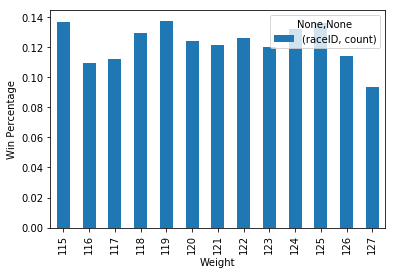

In [12]:
#TODO: Get weight of the race and calculate the difference between the racing horse and the race 
winners_by_weight = df_horses[df_horses['OfficialFinish'] == 1][['raceID','Weight']].groupby('Weight').agg(['count'])
winners_by_weight = winners_by_weight[winners_by_weight > 30].dropna()
weight_count = df_horses[['raceID','Weight']].groupby('Weight').agg(['count'])
pct_winners_by_weight = winners_by_weight/weight_count[weight_count.index.isin(winners_by_weight.index)]
ax = pct_winners_by_weight.plot(kind='bar')
ax.set_ylabel("Win Percentage")
del winners_by_weight, weight_count, pct_winners_by_weight

In [13]:
#TODO: Convert Jockey name into int
#Use: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
#TODO: Finish either using pandas categorical or the OneHotEncoder


In [14]:
#TODO: Remove Odds
#Assign features and encode categorical features
numeric_features = ['raceID', 'Post', 'Weight', 'OfficialFinish', 'RestDays', 'Age', 'Odds']
#Other options, Odds, claimValue, WeightDifference(Engineered), WeightDiffForRace(Engineered), DaysSinceLastRest(Engineered)
categorical_features = ['JockeyName', 'Sex', 'BreedType', 'Trainer', 'Owner']
#Other options, Trainer, Owner

#convert to factors
for feature in categorical_features:
    df_horses[feature] = df_horses[feature].astype(str)
    df_horses[feature] = df_horses[feature].replace('nan','0') #have to do this because of a weird random forest bug

    df_features = df_horses[numeric_features]

for feature in categorical_features:
    encoded_features = pd.get_dummies(df_horses[feature])
    encoded_features.columns = feature + encoded_features.columns
    df_features = pd.merge(df_features,encoded_features,left_index=True,right_index=True,how='inner') 

#turn the target variable into a binary feature: did or did not win
df_features['win'] = False
df_features.loc[df_features['OfficialFinish'] == 1,'win'] = True

In [15]:
training_races = np.random.choice(df_features['raceID'].unique(),size=int(round(0.7*len(df_features['raceID'].unique()),0)),replace=False)
df_train = df_features[df_features['raceID'].isin(training_races)]
df_test = df_features[~df_features['raceID'].isin(training_races)]


In [22]:
#TODO: Set verbose to true to see progress
gbm = xgb.XGBClassifier(objective='binary:logistic').fit(df_train.drop(df_train[['win','OfficialFinish','raceID', 'Odds']],axis=1)
, df_train['win'])
predictions = gbm.predict_proba(df_test.drop(df_test[['win','OfficialFinish','raceID', 'Odds']],axis=1))[:,0]
df_test['predictions'] = predictions
df_test = df_test[['predictions','win','raceID', 'Odds']]

KeyError: "['OfficialFinish' 'Odds'] not in index"

In [ ]:
df_test[0:5]

In [ ]:
#Figure out 2 hour odds
#df_odds = df_horses[['Odds', 'raceID']]
#df_test2 = pd.merge(df_test, df_odds, how='outer',on=df_odds.columns.tolist(),left_index=True,right_index=True)
#df_test2 = pd.concat([df_odds, df_test]).groupby('raceID').last().fillna(value='None')
#df_test2[0:5]
#df_odds = df_odds[df_odds['raceID'].isin(df_test.index)]
#df_odds[0:5]

In [ ]:
#df_odds.loc[df_odds['raceID'] == 6581852018111411]

In [21]:
#TODO: Export this to csv to analyze prediction accuracy
df_test[0:5]

,predictions,win,raceID
0,0.903065,False,6581852018111411
2,0.867427,True,6581852018111413
3,0.867427,False,6581852018111414
7,0.898969,False,6581852018111422
15,0.867427,False,6581852018111434


In [ ]:
#select the horse I picked as most likely to win
df_profit = df_test.loc[df_test.groupby("raceID")["predictions"].idxmax()]
df_profit
investment = 0
payout = 0
for index, row in df_profit.iterrows():
    investment +=1
    
    if (row['win']):
        payout += row['Odds']

investment_return = round((payout - investment)/investment*100,2)
print("This algorithm and betting system will generate a " + str(investment_return) + "% return\n")
print("Note: you can't read much from a single run. Best to setup a cross validation framework and look at the return over many runs")

In [ ]:
#TODO: Remove Odds from decision process